In [1]:
import torch
import torch.nn as nn
import data.datasets as dataSource
import torch.utils.data as tdata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import magnetoptimiser
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")


import cvxpy as cp

/home/max/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/max/florian/magnetoptimiser/src/magnetoptimiser/wrappers.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer

In [2]:
dataset_train, dataset_val = dataSource.Dipole_H_train, dataSource.Dipole_H_val
#print(dataset_train.input_columns)
batch_size = 16
important_cols = ["B_design","aper_x", "aper_y", "fieldTolerance", "maxCurrentDensity" , "rho0", "w_leg_factor", "usedPowerInPercent"]
important_cols_order = sorted(important_cols,key=lambda c: dataset_train.input_columns.index(c))

print(important_cols)
print(important_cols_order)

input_mask = [True if col in important_cols else False for col in dataset_train.input_columns]
train_loader, val_loader = tdata.DataLoader(dataset_train,batch_size), tdata.DataLoader(dataset_val,batch_size)

target_index_dict = {col:i for i,col in enumerate(dataset_train.target_columns)}
target_cols = ["B0","gfr_x_1e-2","gfr_y_1e-2"]
output_mask = [True if col in target_cols else False for col in dataset_train.target_columns]

['B_design', 'aper_x', 'aper_y', 'fieldTolerance', 'maxCurrentDensity', 'rho0', 'w_leg_factor', 'usedPowerInPercent']
['fieldTolerance', 'maxCurrentDensity', 'rho0', 'usedPowerInPercent', 'w_leg_factor', 'B_design', 'aper_x', 'aper_y']


In [3]:
network_wrapper = magnetoptimiser.wrappers.Wrapper_Dipole_Hshape_RegNet_v002

In [6]:
errors = {error_type: {"B0":[],"gfr_x":[],"gfr_y":[]} for error_type in ["abs","rel","mse"]}
scatter_plot_points = {"B0":[],"gfr_x":[],"gfr_y":[]}
single_sample_loader =  tdata.DataLoader(dataset_val, 1)

for x,y in single_sample_loader:
    selected_x = x[:,input_mask].double()
    #print(selected_x)
    selected_y = y[:,output_mask].double()
    pred = network_wrapper.predict(selected_x)[:,output_mask]
    scatter_plot_points["B0"].append((pred[:,0],selected_y[:,0]))
    scatter_plot_points["gfr_x"].append((pred[:,1],selected_y[:,1]))
    scatter_plot_points["gfr_y"].append((pred[:,2],selected_y[:,2]))

    #print(pred,selected_y)
    abs_errors = pred - selected_y.numpy()
    errors["abs"]["B0"].append(abs_errors[:,0])
    errors["abs"]["gfr_x"].append(abs_errors[:,1])
    errors["abs"]["gfr_y"].append(abs_errors[:,2])

    rel_errors = 1 - (pred/selected_y.numpy())
    errors["rel"]["B0"].append(rel_errors[:,0])
    errors["rel"]["gfr_x"].append(rel_errors[:,1])
    errors["rel"]["gfr_y"].append(rel_errors[:,2])

    mse_error = (pred - selected_y.numpy())**2
    errors["mse"]["B0"].append(mse_error[:,0])
    errors["mse"]["gfr_x"].append(mse_error[:,1])
    errors["mse"]["gfr_y"].append(mse_error[:,2])
    
mean_errors = {error_type: {quantity: sum(map(lambda v: abs(v),l))/len(l) for quantity, l in dictt.items()} for error_type, dictt in errors.items()}
max_errors = {error_type: {quantity: max(map(lambda v: abs(v),l)) for quantity, l in dictt.items()} for error_type, dictt in errors.items()}
print(mean_errors)
print(max_errors)

{'abs': {'B0': array([0.00430999]), 'gfr_x': array([0.00250086]), 'gfr_y': array([0.0004026])}, 'rel': {'B0': array([0.01795317]), 'gfr_x': array([0.01173353]), 'gfr_y': array([0.01063535])}, 'mse': {'B0': array([3.16308074e-05]), 'gfr_x': array([1.30223782e-05]), 'gfr_y': array([2.54520974e-07])}}
{'abs': {'B0': array([0.03350081]), 'gfr_x': array([0.0373228]), 'gfr_y': array([0.00282468])}, 'rel': {'B0': array([0.83611439]), 'gfr_x': array([0.17728776]), 'gfr_y': array([0.08162017])}, 'mse': {'B0': array([0.0011223]), 'gfr_x': array([0.00139299]), 'gfr_y': array([7.97881351e-06])}}


In [7]:
cols = {"B0":{"pred":[],"target":[]},"gfr_x":{"pred":[],"target":[]},"gfr_y":{"pred":[],"target":[]}}
single_sample_loader =  tdata.DataLoader(dataset_val, 1)

for x,y in single_sample_loader:
    
    selected_x = x[:,input_mask].double()
    target = y[:,output_mask].double()
    pred = network_wrapper.predict(selected_x)[:,output_mask]

    cols["B0"]["pred"].append(pred[:,0][0])
    cols["B0"]["target"].append(target[:,0].numpy()[0])

    cols["gfr_x"]["pred"].append(pred[:,1][0])
    cols["gfr_x"]["target"].append(target[:,1].numpy()[0])

    cols["gfr_y"]["pred"].append(pred[:,2][0])
    cols["gfr_y"]["target"].append(target[:,2].numpy()[0])


In [8]:
col_names = [quantity + "_" + col_name for quantity, measures in cols.items() for col_name,_ in measures.items()]
df = pd.DataFrame([row for row in zip(*[col for quantity, measures in cols.items() for _,col in measures.items()])],columns=col_names)
df = df \
.assign(B0_diff=df.apply(lambda r: r["B0_pred"] - r["B0_target"] ,axis=1))\
.assign(gfr_x_diff=df.apply(lambda r: r["gfr_x_pred"] - r["gfr_x_target"] ,axis=1))\
.assign(gfr_y_diff=df.apply(lambda r: r["gfr_y_pred"] - r["gfr_y_target"] ,axis=1))\
.assign(B0_diff_abs=df.apply(lambda r: abs(r["B0_pred"] - r["B0_target"]) ,axis=1))\
.assign(gfr_x_diff_abs=df.apply(lambda r: abs(r["gfr_x_pred"] - r["gfr_x_target"]) ,axis=1))\
.assign(gfr_y_diff_abs=df.apply(lambda r: abs(r["gfr_y_pred"] - r["gfr_y_target"]) ,axis=1))\
.assign(B0_diff_rel=df.apply(lambda r: abs(1 -r["B0_pred"]/r["B0_target"]) ,axis=1))\
.assign(gfr_x_diff_rel=df.apply(lambda r: abs(1 - r["gfr_x_pred"]/r["gfr_x_target"]) ,axis=1))\
.assign(gfr_y_diff_rel=df.apply(lambda r: abs(1 - r["gfr_y_pred"]/r["gfr_y_target"]) ,axis=1))

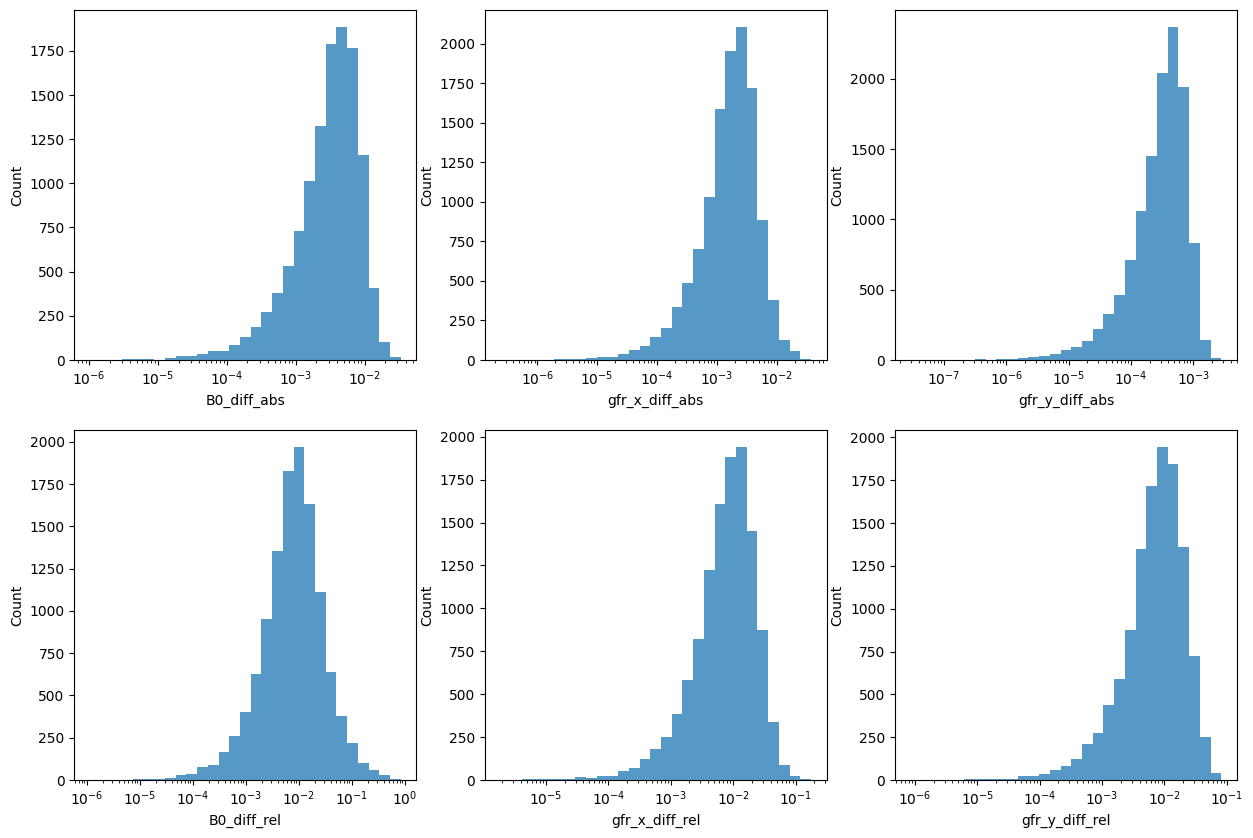

In [9]:

fig, axes = plt.subplots(2,3,figsize=(15,10))

for x,y,colname in [(0,0,"B0_diff_abs"),(0,1,"gfr_x_diff_abs"),(0,2,"gfr_y_diff_abs"),(1,0,"B0_diff_rel"),(1,1,"gfr_x_diff_rel"),(1,2,"gfr_y_diff_rel")]:
    log_min = np.log10(df[colname].min())
    log_max = np.log10(df[colname].max())
    bins = np.logspace(log_min, log_max, 30) 
    sns.histplot(ax=axes[x,y],data=df,x=colname,bins=bins)
    axes[x,y].set_xscale("log")

## Input optimization

In [10]:
A = []
b = []

def onehot(name, neg):
    out = [0] * len(important_cols_order)
    out[important_cols_order.index(name)] = -1 if neg else 1
    return out

for name in important_cols_order:
    # constraints for minima: x > a --> -x < -a
    A.append(onehot(name,True))
    b.append(-dataset_train.input_mins[name])
    
    # constraints for maxima: x < a
    if name == "usedPowerInPercent":
        A.append(onehot(name,False))
        b.append(100)
    else:
        A.append(onehot(name,False))
        b.append(dataset_train.input_maxs[name])



In [46]:
A_rel = []
b_rel = []

#['fieldTolerance', 'maxCurrentDensity', 'rho0', 'usedPowerInPercent', 'w_leg_factor', 'B_design', 'aper_x', 'aper_y']

# aper_x > aper_y --> aper_y - aper_x < 0
A_rel.append([0, 0, 0, 0, 0, 0, -0.999, 1])
b_rel.append(0)

# aper_x < 5 * aper_y --> aper_x - 5 * aper_y < 0
A_rel.append([0, 0, 0, 0, 0, 0, 1, -3])
b_rel.append(0)



A = A + A_rel
b = b + b_rel

In [47]:
# ratio constraints 
# compute min and max ratio for every pair of inputs and ensure the ratio is in that range with two linear constraints
# e.g. min < a/b < max -->  min * b - a < 0 and a - max * b < 0
# with slack. min * (1+e) < a/b < max * (1-e) -->  (min (1+ e)) * b - a < 0 and a - (max*(1-e)) * b < 0

A_rat = []
b_rat = []
epsilon = 1e-5

for i in range(len(important_cols_order)-1):
    for j in range(i+1,len(important_cols_order)):
        quantity_1 = important_cols_order[i]
        quantity_2 = important_cols_order[j]

        # ratio = column i/ colimn j
        ratio_df = dataset_train.dataframe.assign(ratio=dataset_train.dataframe.apply(lambda r: r[quantity_1] / r[quantity_2], axis=1))

        minimum = ratio_df["ratio"].min() 
        maximum = ratio_df["ratio"].max()

        minimum *= 1+epsilon
        maximum *= 1-epsilon

        # min * j - i < 0
        min_row = [0]*len(important_cols)
        min_row[i] = -1
        min_row[j] = minimum
        A_rat.append(min_row)
        b_rat.append(0)

        #i - max * k < 0
        max_row = [0]*len(important_cols)
        max_row[i] = 1
        max_row[j] = -maximum
        A_rat.append(max_row)
        b_rat.append(0)

        print(quantity_1,quantity_2,minimum,maximum, "-->", min_row,"< 0 and", max_row,"< 0")


A = A + A_rat
b = b + b_rat

fieldTolerance maxCurrentDensity 1.0000100000000001e-05 0.0199998 --> [-1, 1.0000100000000001e-05, 0, 0, 0, 0, 0, 0] < 0 and [1, -0.0199998, 0, 0, 0, 0, 0, 0] < 0
fieldTolerance rho0 0.00010000100000000001 0.0199998 --> [-1, 0, 0.00010000100000000001, 0, 0, 0, 0, 0] < 0 and [1, 0, -0.0199998, 0, 0, 0, 0, 0] < 0
fieldTolerance usedPowerInPercent 8.000080000000001e-07 0.0009372486996250448 --> [-1, 0, 0, 8.000080000000001e-07, 0, 0, 0, 0] < 0 and [1, 0, 0, -0.0009372486996250448, 0, 0, 0, 0] < 0
fieldTolerance w_leg_factor 4.12525439843647e-05 0.012235506744198137 --> [-1, 0, 0, 0, 4.12525439843647e-05, 0, 0, 0] < 0 and [1, 0, 0, 0, -0.012235506744198137, 0, 0, 0] < 0
fieldTolerance B_design 5.0000500000000003e-05 0.13557761627338663 --> [-1, 0, 0, 0, 0, 5.0000500000000003e-05, 0, 0] < 0 and [1, 0, 0, 0, 0, -0.13557761627338663, 0, 0] < 0
fieldTolerance aper_x 0.00033333666666666674 0.33333000000000007 --> [-1, 0, 0, 0, 0, 0, 0.00033333666666666674, 0] < 0 and [1, 0, 0, 0, 0, 0, -0.33333

In [48]:
def project_to_polytope(x, A_mat=A, b_vec = b):
    # Define decision variable
    p = cp.Variable(len(x))
    # Define objective function
    objective = cp.Minimize(cp.sum_squares(p - x))

    # Define constraints
    constraints = [np.array(A_mat) @ p <= np.array(b_vec)]

    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()


    # Optimal solution
    closest_point = p.value
    return closest_point

In [49]:
network = network_wrapper.model
scaler_input = network_wrapper.scaler_x
scaler_output = network_wrapper.scaler_y
network.to(device)

RegressionNetwork(
  (layer1): Linear(in_features=8, out_features=256, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (output_layer): Linear(in_features=256, out_features=34, bias=True)
)

In [50]:
def create_loss_function(tuple_of_interest, target, scaler_output):
    mask = torch.zeros(1,34,dtype=torch.float).to(device)
    full_target = np.zeros((1,34))
    for i in tuple_of_interest:
        mask[0, i] = 1

    full_target[0,0] = target[0]
    full_target[0,tuple_of_interest[1]] = target[1]
    full_target[0,tuple_of_interest[2]] = target[2]
    scaled_target = torch.tensor(scaler_output.transform(full_target), dtype=torch.float).to(device)
    mse = torch.nn.MSELoss().to(device)
    def instanciated_loss_function(x):
        return mse(x*mask,scaled_target*mask)
    return instanciated_loss_function


In [51]:
'''
    - optim tuple: (B0,gfr_x, gfr_y)
    - gfr_accuracies (gfr_x_acc, gfr_y_acc) 
        To select the correct outputs of the network to optimize towards
    - initial condidions double array of size 8 in order of dataset
    - vary_input: boolean array of size 8, should input i be fixed or adjusted
    - extra boundary conditions for polytope (A,b)
'''
disable_projection = True

def optim(optim_tuple={"B0":0.8,"gfr_x":0.1,"gfr_y":0.05}, gfr_accuracies=("1e-3","1e-3"), initial_conditions=np.random.random(8), vary_input=[True] * 8, extra_boundary_conditions=([],[])):



    #target_mask = [False] * 34
    #target_mask[0] = True
    #target_mask[target_index_dict[f"gfr_x_{gfr_accuracies[0]}"]] = True
    #target_mask[target_index_dict[f"gfr_y_{gfr_accuracies[1]}"]] = True
    target = [optim_tuple["B0"],optim_tuple["gfr_x"],optim_tuple["gfr_y"]]

    vary_input_tensor = torch.tensor(vary_input).to(device)
    loss_fun = create_loss_function([0,target_index_dict[f"gfr_x_{gfr_accuracies[0]}"],target_index_dict[f"gfr_y_{gfr_accuracies[1]}"]], target, scaler_output)
    
    A_intern = A + extra_boundary_conditions[0]
    b_intern = b + extra_boundary_conditions[1]

    # apertur > gfr
    #A_intern.append([0, 0, 0, 0, 0, 0, -1, 0])
    #b_rel.append(-optim_tuple["gfr_x"])
    #A_intern.append([0, 0, 0, 0, 0, 0, 0, -1])
    #b_rel.append(-optim_tuple["gfr_y"])
    try:
        guess = project_to_polytope(initial_conditions,A_intern,b_intern)
    except:
        guess = initial_conditions
    
    guess[3] = 100
    vary_input_tensor[3] = False

    lr = 1e-1
    n_steps = 20000
    k = 0

    best_guess = None
    best_guess_loss = 10000000

    for step in range(n_steps):
        for name, layer in network.named_parameters():
            if layer.grad is not None:
                layer.grad.zero_()
        
        scaled_guess = scaler_input.transform(guess.reshape(1, -1))
        grad_guess = torch.tensor(scaled_guess,requires_grad=True,device=device,dtype=torch.float).to(device)
        pred = network(grad_guess)
        loss = loss_fun(pred)
        if loss < 0.1:
            lr = 1e-1
        
        if loss < 0.01:
            lr = 1e-2
        
        if loss < 0.001:
            lr = 1e-3
        loss.backward()
        next_guess = (grad_guess - lr * grad_guess.grad) * vary_input_tensor + (grad_guess * (~vary_input_tensor))
        next_guess_unscaled = scaler_input.inverse_transform(next_guess.detach().cpu().numpy())
        if disable_projection:
            guess = next_guess_unscaled[0,:] 
        else:
            if k % 100 == 0:
                try:
                    next_guess_projected = project_to_polytope(next_guess_unscaled[0,:] ,A_intern, b_intern)
                    #print("solver successful")
                except:
                    next_guess_projected = next_guess_unscaled[0,:] 
                    #print("solver failed")
                k = 1
            else:
                k = k + 1
            guess = next_guess_projected

        if loss < best_guess_loss:
            best_guess = guess
            best_guess_loss = loss
            #print(f"new best {best_guess_loss}")

        #print(step,loss.item())
        #print(scaler_output.inverse_transform(pred.detach().cpu().numpy())[0,0],
        #      scaler_output.inverse_transform(pred.detach().cpu().numpy())[0,target_index_dict[f"gfr_x_{gfr_accuracies[0]}"]],
        #      scaler_output.inverse_transform(pred.detach().cpu().numpy())[0,target_index_dict[f"gfr_y_{gfr_accuracies[1]}"]])


    return project_to_polytope(best_guess,A_intern, b_intern)


params = optim()
print(params)

[9.97219682e-03 1.06262751e+00 8.90219010e-01 9.99793754e+01
 8.13621997e-01 8.99142662e-01 1.34404630e-01 9.88864120e-02]


#['fieldTolerance', 'maxCurrentDensity', 'rho0', 'usedPowerInPercent', 'w_leg_factor', 'B_design', 'aper_x', 'aper_y']


In [52]:
import femmcreator
import magnetdesigner
#['fieldTolerance', 'maxCurrentDensity', 'rho0', 'usedPowerInPercent', 'w_leg_factor', 'B_design', 'aper_x', 'aper_y']

magnet = magnetdesigner.designer.get_Dipole(
    name=name, 
    B_design=params[5], 
    aper_x=params[6], 
    aper_y=params[7], 
    fieldTolerance=params[0], 
    rho0=params[2], 
    w_leg_factor=params[4],
    maxCurrentDensity=params[1], 
    usedPowerInPercent=params[3], 
    shape="H")

femm = femmcreator.FEMM()
femm.Build(magnet.get_femminput)
femm.CreateFEMM('dipole_H_0.1_0.1_0.05')

In [53]:
print(magnet.magnet2D.yokeAreaTotal)
print(magnet.magnet2D.coilAreaTotal)
print(magnet.magnet2D.yokeCostTotal)
print(magnet.magnet2D.coilCostTotal)
print(magnet.operatingCosts)
print(magnet.powerConsumption)


0.4490793350102557
0.13316625936431736
49504.70957419055
135356.94171922968
38896.230987794974
0.0037044029512185686


In [54]:
network_wrapper.predict(params.reshape(1, -1))
scaler_output.inverse_transform(network(torch.tensor(scaler_input.transform(params.reshape(1, -1)),device=device,dtype=torch.float)).cpu().detach().numpy())

array([[ 7.71559179e-01, -1.68108054e-05,  7.33585469e-03,
         9.90128610e-03,  1.55358175e-02,  2.14558374e-02,
         2.72897258e-02,  3.97511125e-02,  4.81781960e-02,
         6.36481196e-02,  7.11746961e-02,  8.23676810e-02,
         9.19070095e-02,  1.05651222e-01,  1.18446440e-01,
         1.29120082e-01,  1.44845635e-01,  1.56416729e-01,
         6.03875658e-03,  9.12610907e-03,  1.67916063e-02,
         2.48958785e-02,  3.45002860e-02,  4.60467190e-02,
         4.58293520e-02,  4.63668630e-02,  4.95130122e-02,
         4.90440130e-02,  4.95478623e-02,  4.97533567e-02,
         4.99941558e-02,  5.04068770e-02,  5.02693839e-02,
         5.02589531e-02]], dtype=float32)

In [ ]:
#['fieldTolerance', 'maxCurrentDensity', 'rho0', 'usedPowerInPercent', 'w_leg_factor', 'B_design', 'aper_x', 'aper_y']
def cost_fun(params):
    magnet = magnetdesigner.designer.get_Dipole(
        name=name, 
        B_design=params[5], 
        aper_x=params[6], 
        aper_y=params[7], 
        fieldTolerance=params[0], 
        rho0=params[2], 
        w_leg_factor=params[4],
        maxCurrentDensity=params[1], 
        usedPowerInPercent=params[3], 
    shape="H")

    return magnet.magnet2D.yokeCostTotal + magnet.magnet2D.coilCostTotal

def well_distributed_init_Params():

    init_params = np.random.random(8)
    for i,name in enumerate(important_cols_order):
        cur_min = dataset_train.input_mins[name]
        cur_max = dataset_train.input_maxs[name]
        init_params[i] = np.random.random() * (cur_max - cur_min) + cur_min
    return init_params

population = []

def optim_cheapest_magnet(optim_tuple={"B0":1.2,"gfr_x":0.15,"gfr_y":0.1}, gfr_accuracies=("1e-3","1e-3")):
    cheapest = 1000000000
    cheapest_params = None

    for i in range(500):
        init_params = well_distributed_init_Params()
        params = optim(optim_tuple, gfr_accuracies, init_params)
        cost = cost_fun(params)
        pred = network_wrapper.predict(params.reshape(1, -1))
        pred_dict = {"B0":pred[0,0],"gfr_x":pred[0,target_index_dict[f"gfr_x_{gfr_accuracies[0]}"]],"gfr_y":pred[0,target_index_dict[f"gfr_y_{gfr_accuracies[1]}"]]}
        print("magnet " + str(i))
        print(pred_dict)
        print(cost)
        if cost < cheapest:
            cheapest = cost
            cheapest_params = params
        
        population.append({"init_params":init_params,"params":params,"cost":cost,"network_pred": pred_dict})

    return cheapest_params

        

In [56]:
optim_cheapest_magnet({"B0":1.2,"gfr_x":0.15,"gfr_y":0.1})

magnet 0
{'B0': 1.1983317, 'gfr_x': 0.16595633, 'gfr_y': 0.09756537}
506560.5248543268
magnet 1
{'B0': 1.1760893, 'gfr_x': 0.15416515, 'gfr_y': 0.09037457}
186152.34284877137
magnet 2
{'B0': 1.1915334, 'gfr_x': 0.15040974, 'gfr_y': 0.090190575}
334974.9612185498
magnet 3
{'B0': 1.2031281, 'gfr_x': 0.16478951, 'gfr_y': 0.09967679}
359649.0142615552
magnet 4
{'B0': 1.2272573, 'gfr_x': 0.18591219, 'gfr_y': 0.07328023}
243861.41916147814
magnet 5
{'B0': 1.2052121, 'gfr_x': 0.16210586, 'gfr_y': 0.08657127}
408231.8588677653
magnet 6
{'B0': 1.1642821, 'gfr_x': 0.16423032, 'gfr_y': 0.089245796}
1286576.3284699335
magnet 7
{'B0': 1.1864539, 'gfr_x': 0.15690227, 'gfr_y': 0.09774176}
329520.8423682412
magnet 8
{'B0': 1.2264556, 'gfr_x': 0.17315362, 'gfr_y': 0.09210972}
510670.5619975249
magnet 9
{'B0': 1.2379731, 'gfr_x': 0.16927502, 'gfr_y': 0.072345674}
422026.1848449708
magnet 10
{'B0': 1.2353857, 'gfr_x': 0.17079596, 'gfr_y': 0.07923018}
468033.7572049156
magnet 11
{'B0': 1.2125401, 'gfr_x':

array([6.82248361e-03, 8.51966667e+00, 8.17994177e-01, 1.00000000e+02,
       8.56972992e-01, 1.26508713e+00, 1.75700610e-01, 1.75524909e-01])

In [57]:
population[-1]

{'init_params': array([7.85599998e-03, 7.82131868e+00, 7.28925171e-01, 3.86980468e+01,
        1.28417664e+00, 1.50982121e+00, 2.82376014e-01, 1.23592159e-01]),
 'params': array([9.18749347e-03, 7.57481956e+00, 7.30017126e-01, 1.00000000e+02,
        1.26621521e+00, 1.23113334e+00, 1.96099143e-01, 1.95903044e-01]),
 'cost': 299214.729779959,
 'network_pred': {'B0': 1.2288187, 'gfr_x': 0.16074175, 'gfr_y': 0.09950178}}

(array([23., 31., 29.,  5.,  7.,  1.,  1.,  1.,  1.,  1.]),
 array([ 184330.50356062,  318345.32070191,  452360.1378432 ,
         586374.95498448,  720389.77212577,  854404.58926706,
         988419.40640835, 1122434.22354964, 1256449.04069092,
        1390463.85783221, 1524478.6749735 ]),
 <BarContainer object of 10 artists>)

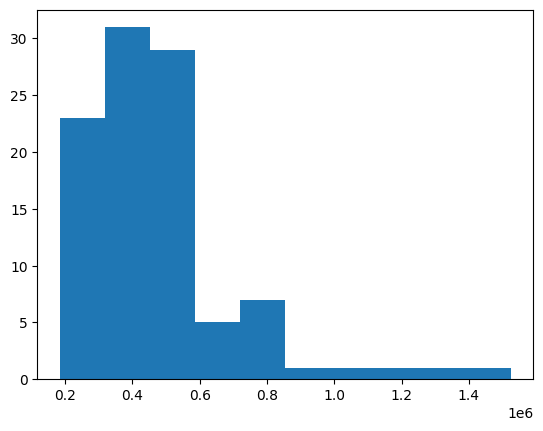

In [58]:
plt.hist(list(map(lambda m: m["cost"], population)))